# Wedding table optimization

## Mathematical definition

In this notebook, we're going to attempt finding an optimal solution to the problem of wedding guest allocation, which is an example of Mixed Integer Linear Program (MILP), also known under a different formulation as the *quadratic knapsack problem (QKP)*.

In particular, the following happiness function will be minimized:
$$ \min_{x_i^j, x_i^k}  \sum_{i=0}^n \sum_{j=0}^{m-2} \sum_{k=j+1}^{m-1} \left( - C^{j,k} p_i^{j,k} \right) $$ 

subject to the following constraints:
$$ \sum_i^n x_i^j = 1,  \forall j  $$
$$ a \leq \sum_j^m x_i^j \leq b, \forall i $$
$$ x_i^j, x_i^k, p_i^{j,k} \in \left\{ 0, 1 \right\} $$
$$ a x_i^k \leq \sum_j^m p_i^{j,k} \leq b x_i^k, \forall i,k $$
$$ a x_i^j \leq \sum_k^m p_i^{j,k} \leq b x_i^j, \forall i,j $$

given:
* $n$ tables, and $m$ guests
* $ x_i^j = 1 $ if guest $j$ sits at table $i$
* $ p_i^{j,k} = x_i^j x_i^k = 1 $ if guests $j$ and $k$ both sit at table $i$
* $a$ and $b$ respectively the minimum and maximum number of people at a table
* $C^{j,k} = f(j,k)$ is the connection score between guests $j$ and $k$.


Furthermore, the connection score will be calculated based on the following empirical formula:

$$ C^{j,k} = \sum_{p} c_p \alpha_p^{j,k} $$

where $p$ parameters are taken into account, including
* languages
* age
* partnerships
* city of residence
* interests
* etc...

## Data preparation

Let's import the libraries we will need:
* Pandas for data inport and manipulation
* Pyomo for solving our MILP
* Numpy for math

In [1]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo

We also need to import our test data from the folder structure.

In [2]:
df = pd.read_csv('../testing.csv')
df.set_index(['name', 'lastName'], inplace=True)
df.head()

,,partner,languages,age,city,interests
name,lastName,,,,,
Jamiya,Mejia,3.0,italian|english,30,Messina|IT,politics
John,Baker Lynn,2.0,italian|english,35,Messina|IT,law
Ezekiel,Taylor,5.0,turkish|english|italian,60,Roma|IT,NaN
Douglas,Lynn,4.0,italian,60,Roma|IT,law
Frida,Solis,NaN,italian|english,30,Berlin|DE,engineering


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12 entries, ('Jamiya', 'Mejia') to ('Trevor', 'Patrick')
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   partner    8 non-null      float64
 1   languages  12 non-null     object 
 2   age        12 non-null     int64  
 3   city       12 non-null     object 
 4   interests  11 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.4+ KB


### Encoding

First, we need to correct the index of 'Partner' to ensure that the correct index is preserved (1 for header, 1 for 0-indexing)

In [4]:
df1 = df.copy()
df1.partner -= 2
df1.head()

,,partner,languages,age,city,interests
name,lastName,,,,,
Jamiya,Mejia,1.0,italian|english,30,Messina|IT,politics
John,Baker Lynn,0.0,italian|english,35,Messina|IT,law
Ezekiel,Taylor,3.0,turkish|english|italian,60,Roma|IT,NaN
Douglas,Lynn,2.0,italian,60,Roma|IT,law
Frida,Solis,NaN,italian|english,30,Berlin|DE,engineering


Then, we can convert our string values to one-hot-encoded values, which gives us the array $\boldsymbol{\alpha}_{lang}$

In [5]:
df1.languages.tail().str.get_dummies()

,,dutch,english,french,italian
name,lastName,,,,
Zack,Sherman,0,1,1,0
Larissa,Espinoza,0,1,0,0
Samantha,Mejia,0,1,0,1
Cameron,Rodgers,0,0,0,1
Trevor,Patrick,1,1,0,1


### Connection score function

First, we need to define our weights $\boldsymbol{c}_p$

In [6]:
parameter_weights = pd.Series({
    'partner': 5000,
    'languages': 500,
    'age': -300,
    'city': 50,
    'interests': 100,
    'lastName': 20,
})

Before we can apply this connection score function, we need to create a 3D matrix $\boldsymbol{\lambda}_{p}^{j,k}$ of $c_p^{j,k}$ elements with the following dimensions:
* guest $j$
* guest $k$
* parameter $p$

#### Language coefficient matrix

Let's start with the language. As we've seen before, we can transform our string of languages to one-hot-encoded integer variables, equal to 1 if the guest speaks a given language, and 0 if they don't.

Our language coefficient matrix of $\alpha_{lang}^{j,k}$ should have dimensions $j\times k$. We can obtain such matrix as follows:

$$ \boldsymbol{\lambda}_{lang} = \boldsymbol{\alpha}_{lang} \cdot \boldsymbol{\alpha}_{lang}^T $$

In [7]:
lang_array = df1.languages.str.get_dummies()
lang_matrix = lang_array @ lang_array.T
lang_matrix = np.sqrt(lang_matrix) # introduce diminishing returns
lang_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,1.414214,1.414214,1.414214,1.0,1.414214,1.414214,1.414214,1.0,1.0,1.414214,1.0,1.414214
John,Baker Lynn,1.414214,1.414214,1.414214,1.0,1.414214,1.414214,1.414214,1.0,1.0,1.414214,1.0,1.414214
Ezekiel,Taylor,1.414214,1.414214,1.732051,1.0,1.414214,1.414214,1.414214,1.0,1.0,1.414214,1.0,1.414214
Douglas,Lynn,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.0,1.000000
Frida,Solis,1.414214,1.414214,1.414214,1.0,1.414214,1.414214,1.414214,1.0,1.0,1.414214,1.0,1.414214


#### Age delta

In order to calculate the age delta, we can simply take subtract the age array to its transpose, as follows:

$$ \boldsymbol{\lambda}_{age} = \boldsymbol{\alpha}_{age} - \boldsymbol{\alpha}_{age}^T $$

In [8]:
age_matrix = np.abs(df1.age.array - df1.age.array[:, None])
age_matrix = pd.DataFrame(age_matrix, index=df1.index, columns=df1.index)
age_matrix = (age_matrix - age_matrix.mean()) / age_matrix.std() # normalize data
age_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,-0.509543,-0.297842,0.509543,0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.297842
John,Baker Lynn,-0.072792,-0.893525,0.072792,0.072792,-0.072792,-0.072792,-0.072792,-0.072792,-0.072792,-0.072792,-0.072792,-0.893525
Ezekiel,Taylor,2.110963,2.084892,-2.110963,-2.110963,2.110963,2.110963,2.110963,2.110963,2.110963,2.110963,2.110963,2.084892
Douglas,Lynn,2.110963,2.084892,-2.110963,-2.110963,2.110963,2.110963,2.110963,2.110963,2.110963,2.110963,2.110963,2.084892
Frida,Solis,-0.509543,-0.297842,0.509543,0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.509543,-0.297842


#### City, interests and last name matrix

We can replicate the same approach seen with language for the **city** (country),  **interests** and **last names** matrixes.

In [9]:

city_array = df1.city.str.get_dummies()
city_matrix = city_array @ city_array.T
city_matrix = city_matrix / city_matrix.max() # rescale to 1
city_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,1.0,1.0,0.5,0.5,0.0,0.5,0.5,0.5,0.0,0.5,0.5,0.0
John,Baker Lynn,1.0,1.0,0.5,0.5,0.0,0.5,0.5,0.5,0.0,0.5,0.5,0.0
Ezekiel,Taylor,0.5,0.5,1.0,1.0,0.0,0.5,0.5,0.5,0.0,0.5,0.5,0.0
Douglas,Lynn,0.5,0.5,1.0,1.0,0.0,0.5,0.5,0.5,0.0,0.5,0.5,0.0
Frida,Solis,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, after rescaling, a value of 1 equates to same city, whereas a value of 0.5 equates to same country of residence. 

In [10]:
interest_array = df1.interests.str.get_dummies()
interest_matrix = interest_array @ interest_array.T
interest_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,1,0,0,0,0,1,0,0,0,0,0,0
John,Baker Lynn,0,1,0,1,0,0,0,0,0,0,0,0
Ezekiel,Taylor,0,0,0,0,0,0,0,0,0,0,0,0
Douglas,Lynn,0,1,0,1,0,0,0,0,0,0,0,0
Frida,Solis,0,0,0,0,1,1,1,1,0,1,1,1


In [11]:
last_names_array = df1.reset_index().lastName.str.split(' ').str.join('|').str.get_dummies() # split last names and one-hot-encode
last_names_matrix = last_names_array @ last_names_array.T
last_names_matrix.set_index(df1.index, inplace=True)
last_names_matrix.columns = df1.index
last_names_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,1,0,0,0,0,0,0,0,0,1,0,0
John,Baker Lynn,0,2,0,1,0,0,0,0,0,0,0,0
Ezekiel,Taylor,0,0,1,0,0,0,0,0,0,0,0,0
Douglas,Lynn,0,1,0,1,0,0,0,0,0,0,0,0
Frida,Solis,0,0,0,0,1,0,0,0,0,0,0,0


#### Partners 

Finally, we need a matrix $\boldsymbol{\lambda}_{part}$ such that $c_{part}^{j,k} = 1$ if guest $j$ is the partner of guest $k$ (and vice-versa) and equals 0 everywhere else.

In [12]:
partner_matrix = df1.partner.array == np.arange(df1.partner.size)[:, None]
partner_matrix = pd.DataFrame(partner_matrix, index=df1.index, columns=df1.index, dtype=int)
partner_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,0,1,0,0,0,0,0,0,0,0,0,0
John,Baker Lynn,1,0,0,0,0,0,0,0,0,0,0,0
Ezekiel,Taylor,0,0,0,1,0,0,0,0,0,0,0,0
Douglas,Lynn,0,0,1,0,0,0,0,0,0,0,0,0
Frida,Solis,0,0,0,0,0,0,0,0,0,0,0,0


### Final coefficient matrix and calculation of connection matrix

We're now ready to join all the previous matrices and calculate our connection matrix simply as
$$ C = \sum_p \boldsymbol{\lambda}_p \cdot c_p $$ 

In [13]:
coefficient_matrix = {
    'partner': partner_matrix,
    'languages': lang_matrix,
    'age': age_matrix,
    'city': city_matrix,
    'interests': interest_matrix,
    'lastName': last_names_matrix
}
connection_matrix = sum([coefficient_matrix[key] * val for (key,val) in parameter_weights.items()])
connection_matrix.head()

,name,Jamiya,John,Ezekiel,Douglas,Frida,Cherish,Finley,Zack,Larissa,Samantha,Cameron,Trevor
,lastName,Mejia,Baker Lynn,Taylor,Lynn,Solis,Oconnor,Woodard,Sherman,Espinoza,Mejia,Rodgers,Patrick
name,lastName,,,,,,,,,,,,
Jamiya,Mejia,1029.969635,5846.459291,579.243928,372.137146,859.969635,984.969635,884.969635,677.862854,652.862854,904.969635,677.862854,796.459291
John,Baker Lynn,5778.944332,1165.164310,710.269231,623.162449,728.944332,753.944332,753.944332,546.837551,521.837551,753.944332,546.837551,975.164310
Ezekiel,Taylor,98.817816,106.639214,1569.314369,6183.288965,73.817816,98.817816,98.817816,-108.288965,-133.288965,98.817816,-108.288965,81.639214
Douglas,Lynn,-108.288965,19.532433,6183.288965,1303.288965,-133.288965,-108.288965,-108.288965,-608.288965,-633.288965,-108.288965,-108.288965,-125.467567
Frida,Solis,859.969635,796.459291,554.243928,347.137146,1029.969635,959.969635,959.969635,752.862854,652.862854,959.969635,752.862854,896.459291


### Setting up the optimization problem

Now it's time to formulate the same mathematical problem described at the beginning in terms that the Scipy solver can understand and compute.

Let's start by setting our constraints:

In [14]:
min_guests_per_table = 3 # our $a$
max_guests_per_table = 5
tot_guests = df1.index.size
max_tables = int(np.ceil(tot_guests / min_guests_per_table)) # our $n$

print('a = ', min_guests_per_table, '\nb = ', max_guests_per_table, '\nn = ', max_tables, '\nm = ', tot_guests)

a =  3 
b =  5 
n =  4 
m =  12


#### Define the abstract model

We will now define the abstract model for the mathematical description of our problem.

First, we will define the parameters:
* $m$ number of guests
* $a$ minimum number of guests per table
* $n = m / a$ maximum number of tables
* $b$ maximum number of guests per table
* $\boldsymbol{C}$ matrix of connection coefficients

In [15]:
model = pyo.AbstractModel()

model.max_tables = pyo.Param(default=max_tables)
model.tot_guests= pyo.Param(default=tot_guests)

model.max_guests_per_table = pyo.Param(default=max_guests_per_table)


Then, we can set our iteration ranges $i, j, k$ and our variables $x_i^j, p_i^{j,k}$, where the latter represents the choice of seating guest $j$ with guest $k$ at table $i$.

In [16]:
model.tables_i = pyo.RangeSet(0, model.max_tables - 1)
model.guests_j = pyo.RangeSet(0, model.tot_guests - 1)
model.guests_k = pyo.Set(initialize=model.guests_j)

model.connection_matrix = pyo.Param(model.guests_j, model.guests_k, within=pyo.Reals, default=connection_matrix.to_numpy())


model.x = pyo.Var(model.tables_i, model.guests_j, bounds=(0, 1), within=pyo.Binary)
model.p = pyo.Var(model.tables_i, model.guests_j, model.guests_k, initialize=0, within=pyo.NonNegativeReals)


Next, we can define the relation $p_i^{j,k} = x_i^j x_i^k$ through the following relationships:
1. $$ p_i^{j,k} \leq x_i^j, \forall j\neq k $$
2. $$ p_i^{j,k} \leq x_i^k, \forall k\neq j $$
3. $$ p_i^{j,k} \geq x_i^j + x_i^k - 1, \forall j\neq k $$

as well as the remaining constraints:
* one table per guest $$ \sum_i x_i^j = 1, \forall j $$
* maximum $b$ guests per table $$ \sum_j x_i^j \leq b, \forall i $$


In [17]:

def rule_C1(model, i, j, k):
    return model.p[i, j, k] <= model.x[i,j] if k!=j else pyo.Constraint.Skip
model.connection_matrix1 = pyo.Constraint(model.tables_i, model.guests_j, model.guests_k, rule=rule_C1)

def rule_C2(model, i, j, k):
    return model.p[i, j, k] <= model.x[i,k] if k!=j else pyo.Constraint.Skip
model.connection_matrix2 = pyo.Constraint(model.tables_i, model.guests_j, model.guests_k, rule=rule_C2)

def rule_C3(model, i, j, k):
    return model.p[i, j, k] >= model.x[i,j] + model.x[i, k] - 1 if k!=j else pyo.Constraint.Skip
model.connection_matrix3 = pyo.Constraint(model.tables_i, model.guests_j, model.guests_k, rule=rule_C3)

def rule_one_table_per_guest(model, j):
    return sum(model.x[i, j] for i in model.tables_i) == 1
model.connection_matrix4 = pyo.Constraint(model.guests_j, rule=rule_one_table_per_guest)

def rule_max_guests_per_table(model, i):
    return sum(model.x[i,j] for j in model.guests_j) <= model.max_guests_per_table
model.connection_matrix5 = pyo.Constraint(model.tables_i, rule=rule_max_guests_per_table)


Finally, we can define our Objective Function, that should be maximized by our model. 
$$ \max_{x_i^j} \sum_i \sum_j \sum_{j>k} p_i^{j,k} \cdot C^{j,k} $$ 

In [18]:

model.OF = pyo.Var()
def rule_OF(model):
    return model.OF == sum(
        sum(
            model.p[i, j, k] * model.connection_matrix[j, k] for j in model.guests_j for k in model.guests_k if j>k
        ) for i in model.tables_i
    )
model.COF = pyo.Constraint(rule=rule_OF)
model.obj = pyo.Objective(expr=model.OF, sense=pyo.maximize)

## Mixed Integer Linear Program implementation

We begin by instanciating the model.

In [19]:
instance = model.create_instance()

mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)
mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)


Then, we can select our solver.

In [20]:

opt = pyo.SolverFactory('glpk')

And proceed to solve :)

In [21]:
opt.solve(instance, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmpj2u2tfhh.glpk.raw
 --wglp /var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmp7nu_2afc.glpk.glp
 --cpxlp /var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmplrya8pbs.pyomo.lp
Reading problem data from '/var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmplrya8pbs.pyomo.lp'...
/var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmplrya8pbs.pyomo.lp:9448: warning: lower bound of variable 'x5' redefined
/var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmplrya8pbs.pyomo.lp:9448: warning: upper bound of variable 'x5' redefined
1601 rows, 577 columns, 4057 non-zeros
48 integer variables, all of which are binary
9496 lines were read
Writing problem data to '/var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmp7nu_2afc.glpk.glp'...
8368 lines were written
GLPK Integer Optimizer 5.0
1601 rows, 577 columns, 4057 non-zeros
48 integer variables, all of which are binary

+  3196: >>>>>   3.630779341e+04 <=   5.714146713e+04  57.4% (46; 20)
+  5626: >>>>>   3.670384952e+04 <=   5.356407842e+04  45.9% (80; 31)
+  8311: >>>>>   3.678384952e+04 <=   4.968170763e+04  35.1% (117; 50)
+ 13565: >>>>>   3.711857984e+04 <=   4.748444521e+04  27.9% (193; 70)
+ 53258: mip =   3.711857984e+04 <=     tree is empty   0.0% (0; 1863)
INTEGER OPTIMAL SOLUTION FOUND
Time used:   3.8 secs
Memory used: 5.8 Mb (6104698 bytes)
Writing MIP solution to '/var/folders/15/rx06cwbj24v8xgdcl3vpylmh0000gn/T/tmpj2u2tfhh.glpk.raw'...
2187 lines were written


{'Problem': [{'Name': 'unknown', 'Lower bound': 37118.579843054, 'Upper bound': 37118.579843054, 'Number of objectives': 1, 'Number of constraints': 1601, 'Number of variables': 577, 'Number of nonzeros': 4057, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '1863', 'Number of created subproblems': '1863'}}, 'Error rc': 0, 'Time': 3.7637979984283447}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [22]:
df2 = df1.copy()
df2["table"] = np.zeros(df.index.shape)
for idx, row in enumerate(df2.index):
  for table in range(max_tables):
    df2.loc[row, "table"] += table if instance.x[table, idx].value == 1 else 0
df2

,,partner,languages,age,city,interests,table
name,lastName,,,,,,
Jamiya,Mejia,1.0,italian|english,30,Messina|IT,politics,2.0
John,Baker Lynn,0.0,italian|english,35,Messina|IT,law,2.0
Ezekiel,Taylor,3.0,turkish|english|italian,60,Roma|IT,NaN,1.0
Douglas,Lynn,2.0,italian,60,Roma|IT,law,1.0
Frida,Solis,NaN,italian|english,30,Berlin|DE,engineering,0.0
Cherish,Oconnor,NaN,italian|english,30,Milano|IT,engineering|politics,0.0
Finley,Woodard,NaN,italian|english,30,Milano|IT,engineering,0.0
Zack,Sherman,8.0,french|english,30,Padova|IT,engineering,2.0
Larissa,Espinoza,7.0,english,30,Amsterdam|NL,dentist,2.0


## Genetic Algorithm implementation

Unfortunately, finding a *globally optimal solution* with a numerical method for the real set of invitees (200+) requires age-of-the-universe timeframes with the current computational power. 

There are many algorithms that we could employ to reach a *locally optimal solution* in a much shorter timeframe, such as greedy heuristics, simulated annealing or Genetic Algorithm (GA). We will opt for this latter one, since it displays good performance with modern computer processor designs, which benefit algorithms that can be parallelized.

In order to implement a Genetic Algorithm, we need to specify a few parameters and functions:
* parent selection function - this will select the population that will survive to the next generation
* mutation function - this will introduce mutations to the selected population to generate the new population
* crossover function - this will determine how existing solutions are crossed over to generate the new population

In [23]:
import pygad

### Happiness function

Let's start with defining our happiness function. 

In order to do so, we need to specify some validation functions, such that if the validation is not passed the happiness function will return a large negative value. This ensures that our problem constraints (namely the limit on guests per table) are satisfied. Regarding the other constraint on a single table per guest, it is already expressed by the selection of the variable, which is no longer a binary value, but instead an integer, representing the table the guest will sit at.

Once the validation function is set up, a list of tables, each containing a list of guests sitting at that table, can be drawn up, and the  score of each table can be summed up.

In [24]:
def is_valid_max_guests_per_table(ga_instance, solution):
    return all([np.sum(solution == i) <= max_guests_per_table for i in range(max_tables)])

def validate_solution(ga_instance, solution):
    return is_valid_max_guests_per_table(ga_instance, solution)

def happines_func(ga_instance, solution, _):
    if not validate_solution(ga_instance, solution):
        return -1e4
    tables_list = [np.where(solution == i)[0] for i in range(max_tables)]
    return np.sum([
        np.sum([connection_matrix.iloc[j,k] for j in tables_list[i] for k in tables_list[i] if j > k])
        for i in range(max_tables)
    ])


### Model instanciation and run

Once our happiness (fitness) functions is defined, we are ready to instanciate our Genetic Algorithm model, and specify our parameters for solving it:
* the `num_generations` in conjunction with our `stop_criteria` will determine how many generations the model will keep running for; our *saturate_500* criterion ensures that the model will stop after 500 generations with no improvements in the fitness function,
* `sol_per_pop` specifies the number of solutions (chromosomes) that will be created in each generation,
* `num_genes` is the number of variables, which are constrained to integers in the range [0, `max_tables`] by the `gene_space` parameter,
* `mutation_type = 'adaptive'` causes high-performing chromosomes to mutate disproportionally compared to low-performing ones, according with the percentages defined with the `mutation_percent_genes` parameter.


In [25]:

ga_instance = pygad.GA(
    num_generations=10000,
    stop_criteria='saturate_50',
    num_parents_mating=15,

    sol_per_pop=50,
    num_genes=tot_guests,

    gene_type=int,
    gene_space=np.arange(max_tables),

    parent_selection_type='rws',

    crossover_type='single_point',
    mutation_type='adaptive',
    mutation_percent_genes=[35, 10],

    fitness_func=happines_func,

    random_seed=12345,
)

### Running the model and analyzing results

We're now ready to run our model and review the outputs.

In [26]:
ga_instance.run()

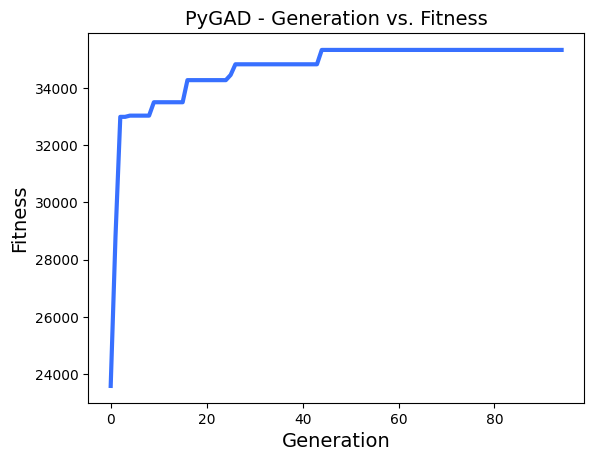

In [27]:
out = ga_instance.plot_fitness()

In [28]:
sol = ga_instance.best_solution()[0]
df3 = df1.copy()
print('Valid solution: ', is_valid_max_guests_per_table(ga_instance, sol))
df3["table"] = sol
[df3.index[np.where(df3['table'] == i)] for i in range(max_tables)]

Valid solution:  True


[MultiIndex([], names=['name', 'lastName']),
 MultiIndex([('Ezekiel',  'Taylor'),
             ('Douglas',    'Lynn'),
             (  'Frida',   'Solis'),
             ('Cherish', 'Oconnor'),
             ( 'Finley', 'Woodard')],
            names=['name', 'lastName']),
 MultiIndex([(  'Jamiya',      'Mejia'),
             (    'John', 'Baker Lynn'),
             ('Samantha',      'Mejia'),
             ( 'Cameron',    'Rodgers'),
             (  'Trevor',    'Patrick')],
            names=['name', 'lastName']),
 MultiIndex([(   'Zack',  'Sherman'),
             ('Larissa', 'Espinoza')],
            names=['name', 'lastName'])]

## Greedy heuristic approach

Finally, a different approach we could use is a greedy heuristic. This type of approach will try to construct a solution by applying an algorithm that will perform a sequence of decisions, choosing the locally maximal option at each step.

An example of such algorithm could be the following - for each table, until all the guests are assigned:
1. start by assigning a random guest for the table
2. then, sample the guest with the highest score in the connection matriix for the guest
3. continue sampling until the table is full, based on the sum of the connection matrices of the guests already seated

In [29]:
nonzero_connection_matrix = connection_matrix - connection_matrix.min() + 1

def sample_from_pool(generator, pool) -> int:
  choice = generator.choice(np.argwhere(pool))[0]
  pool[choice] = 0
  return choice

def pick_best_candidate(solution, table, pool) -> int:
  p_matrix = nonzero_connection_matrix.iloc[solution[table]].sum().reset_index()[0]
  p_matrix[np.nonzero(pool == 0)[0]] = 0
  choice = p_matrix.idxmax()
  pool[choice] = 0
  return choice

def greedy_generator(random_seed:float=0):
  generator = np.random.default_rng(seed=random_seed)
  tables = range(max_tables)
  pool = np.ones(tot_guests)
  solution = [[] for _ in tables]

  for table in tables:
    while len(solution[table]) < max_guests_per_table:
      if pool.sum() == 0:
        return solution
      if len(solution[table]) == 0: 
        solution[table].append(sample_from_pool(generator, pool))
      else:
        solution[table].append(pick_best_candidate(solution, table, pool))

def fitness_fun(solution, ):
  return sum(sum((connection_matrix.iloc[j, k] for j in solution[table] for k in solution[table] if j>k)) for table in range(max_tables))

test_solution = greedy_generator()
print('Solution: ',test_solution,'\nScore: ', fitness_fun(test_solution))

Solution:  [[10, 9, 7, 8, 5], [4, 6, 11, 0, 1], [3, 2], []] 
Score:  36207.793405427095


Our algorithm already produces some outstanding results using no processing time at all. Now we can run this multiple times and select the solution which produces the best fitness.

As matter of fact, since our only random sampling is for the first guest of each table, we can quite easily exhaust the research space in a few iterations.

In [30]:
num_iterations = 100
results = {
  'solution': [],
  'score': []
}

for ii in range(num_iterations):
  sol = greedy_generator(ii)
  results['solution'].append(sol)
  results['score'].append(fitness_fun(sol))


In [31]:
results_df = pd.DataFrame(results) 
id_max = results_df['score'].idxmax()
print(results_df['solution'][id_max], '\nScore: ', results_df['score'][id_max])
[df3.index[results_df['solution'][id_max][ii]] for ii in range(max_tables)]

[[8, 7, 4, 5, 6], [10, 9, 11, 0, 1], [2, 3], []] 
Score:  36788.579843054


[MultiIndex([('Larissa', 'Espinoza'),
             (   'Zack',  'Sherman'),
             (  'Frida',    'Solis'),
             ('Cherish',  'Oconnor'),
             ( 'Finley',  'Woodard')],
            names=['name', 'lastName']),
 MultiIndex([( 'Cameron',    'Rodgers'),
             ('Samantha',      'Mejia'),
             (  'Trevor',    'Patrick'),
             (  'Jamiya',      'Mejia'),
             (    'John', 'Baker Lynn')],
            names=['name', 'lastName']),
 MultiIndex([('Ezekiel', 'Taylor'),
             ('Douglas',   'Lynn')],
            names=['name', 'lastName']),
 MultiIndex([], names=['name', 'lastName'])]

We're approaching the territory of better-than-doing-this-manually. Let's see if this can further be improved!

## Greedy Heuristic Seeded Genetic Algorithm (GHSGA) implementation 

A good way to improve the results provided by the Greedy Heuristic is to use its output to seed the Genetic Algorithm model that we previously initialized.

The first step to do this is to select a population out of our best solutions from the Greedy Heuristic, and convert each solution into a chromosome (sequence of genes) that the Genetic Algorithm can work with.

In [32]:
sol_per_pop = 50

best_solutions = results_df.nlargest(sol_per_pop, 'score')['solution']
initial_population = [pd.Series({idx: table_num for (table_num, table) in enumerate(sol) for idx in table }).sort_index() for sol in best_solutions]

Now that we have the initial population, we can define our new Genetic Algorithm instance and run it.

In [33]:
seeded_ga_instance = pygad.GA(
    initial_population=initial_population,

    num_generations=10000,
    stop_criteria='saturate_50',
    num_parents_mating=15,

    sol_per_pop=sol_per_pop,
    num_genes=tot_guests,

    gene_type=int,
    gene_space=np.arange(max_tables),

    parent_selection_type='rws',

    crossover_type='single_point',
    mutation_type='adaptive',
    mutation_percent_genes=[35, 10],

    fitness_func=happines_func,

    random_seed=12345,
)
seeded_ga_instance.run()

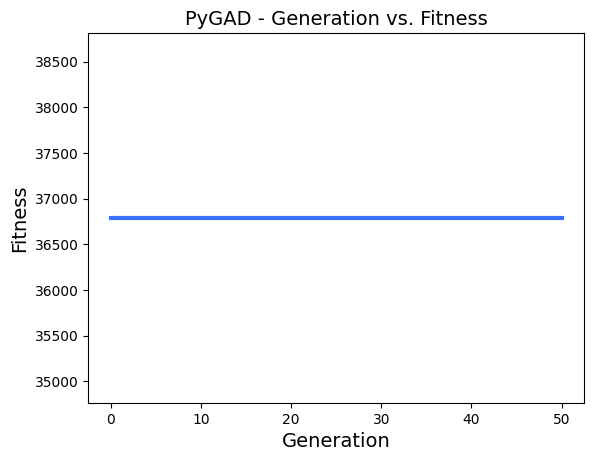

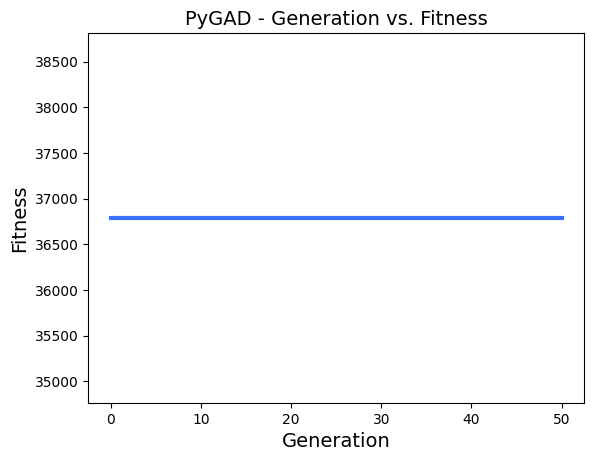

In [34]:
seeded_ga_instance.plot_fitness()

In [35]:
ga_instance.best_solution()

(array([2, 2, 1, 1, 1, 1, 1, 3, 3, 2, 2, 2]), 35325.54594292746, 0)

It appears that the search of the solution space from the Greedy Algorithm was already pretty exhaustive. It would probably require a lot of computational power to improve this solution.